# Poisson Regression

Binomial GLMs are appropriate when the outcome is a count from zero to some known upper bound. If you can analogize the data to the globe tossing model, then you should use a binomial GLM. But often the upper bound isn't known. Instead the counts never get close to any theoretical upper limit. For example. if we go fishing and return with 17 fish, what was the theoretical maximum? Whatever if is, it isn't in our data. How do we model the fish counts?

It turns out the binomial model works here, provided we squint at it in thew right way. When a binomial distribution has a very small probability of an event p, and a very large number of trials N, then it takes on a special shape.

For example, suppose you own a monastery that is in the business, like many monas- teries before the invention of the printing press, of copying manuscripts. You employ 1000 monks, and on any particular day about 1 of them finishes a manuscript. Since the monks are working independently of one another, and manuscripts vary in length, some days pro- duce 3 or more manuscripts, and many days produce none. Since this is a binomial process, you can calculate the variance across days as Np(1 − p) = 1000(0.001)(1 − 0.001) ≈ 1. You can simulate this, for example over 10,000 (1e5) days:

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
y = np.random.binomial(n=1000, p=1 / 1000, size=10_000)
y.mean(), y.var()

(0.993, 0.981751)

The mean and the variance are nearly identical. This is a special shape of the binomial. This special shape is know as the POISSON DISTRIBUTION and it is useful because it allows us to model binomial events for which the number of trials N is unknown or uncountably large.

Suppose for example that you come to own, through imperial drama, another monastery. You don’t know how many monks toil within it, but your advisors tell you that it produces, on average, 2 manuscripts per day. With this information alone, you can infer the entire distribution of numbers of manuscripts completed each day.

To build models with a Poisson distribtuion, the model form is even simplier than it is for a binomial for a Gaussian model. The simplicity arises from the possons only having one parameter that describes its shape, resulting in a data probability definition like:

y = Poisson(lam)

The parameter lam is the expected value of the outcome y. It is also the expected variance of the counts y.

We also need a link function. The conventional link function for a poisson model is the log link, as introduced in the previous chapter. So to embed a linear model, we use:

y = poisson(lam)

log(lam) = alpha + beta(x-xbar)

## Example: Oceanic Tool Complexity

The island societies of Oceania provide a natural experiment in technological evolution. Different historical island populations possessed tool kits of different size. These kits include fish hooks, axes, boats, hand plows, and many other types of tools. A number of theories predict that larger populations will both develop and sustain more complex tool kits. So the natural variation in population size induced by natural variation in island size in Oceania provides a natural experiment to test these ideas

We’ll use this topic to develop a standard Poisson GLM analysis. And then I’ll pivot at the end and also do a non-standard, but more theoretically motivated, Poisson model. The data we’ll work with are counts of unique tool types for 10 historical Oceanic societies:

In [6]:
dk = pd.read_csv("Kline.csv", sep=";")
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [ ]:
import numpy as np

just going to try something out...
How I would normally look at this is try to plot something on the log-normal scale, then maybe fit a linear model to it? I need to understand the benefits of a poisson regression better so I know why this is insufficient

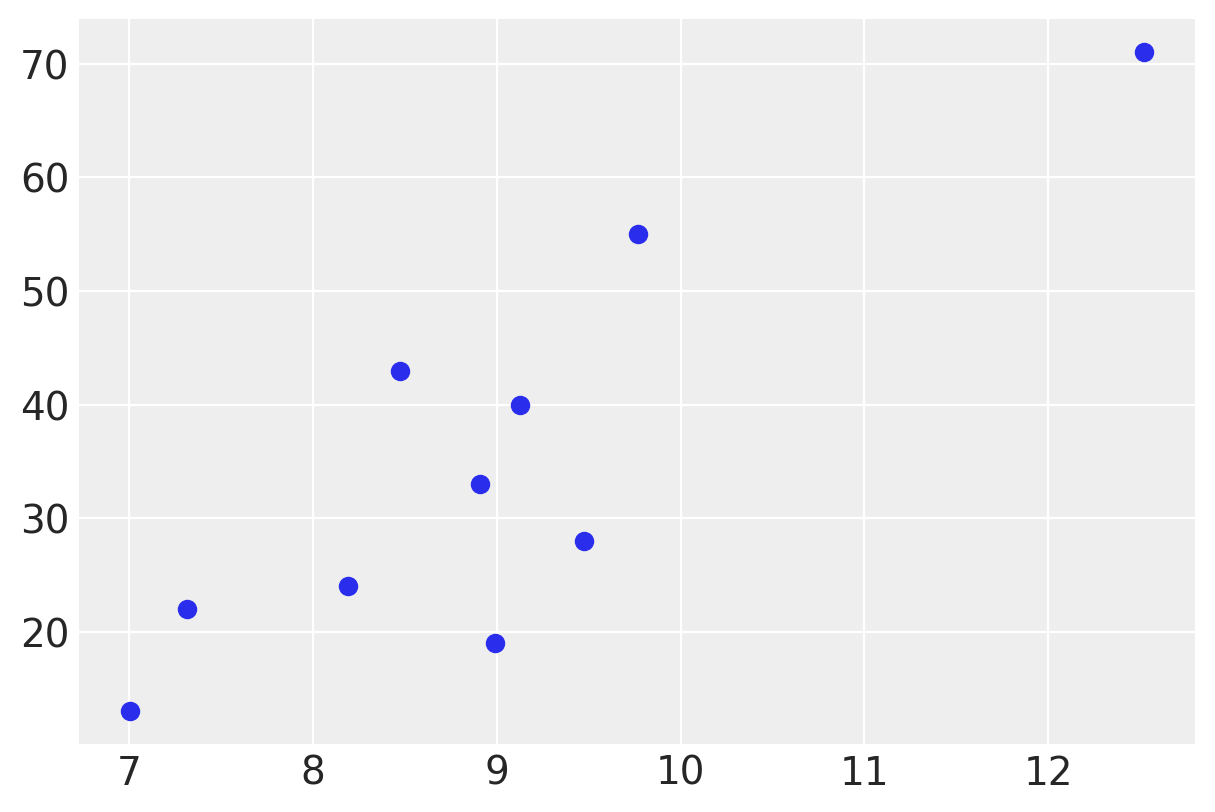

In [12]:
plt.scatter(np.log(dk['population']),dk['total_tools'])

We are going to model the idea that:

 - The number of tools increases with log population size
 - the numebr of tools increases with contact rate among islands
 - The impacy of population on tool counts is moderated by high contact. This is to say that the association between total_tools and log population depends upon contact. So we will look for a positive interaction between log population and contact rate.

In [13]:
P = standardize(np.log(dk.population)).values
c_id = (dk.contact == "high").astype(int).values

The model that conforms to the research hypothesis includes an interation between log-population and contact rate. In math form, this is:

T = Poisson(lam)

log(lam) = alpha_CID + beta_CID * logP

Alpha = to be determined
beta = to be determined

We need to figure out some sensible priors. As with binomial models, the transformation of scale between the scale of a linear model and the count scale off the outcome means that something flat on the linear model scale will not be flat on the outcome scale. Lets comsider for example just a model with an intercept and a vauge Normal(0,10) prior on it.

What does this prior look like on the outcome scale lam? is alpha has a normal distribution, then lam has a log normal distribtuion, so lets plot a log-normal with these values.

In [22]:
from scipy.stats import lognorm

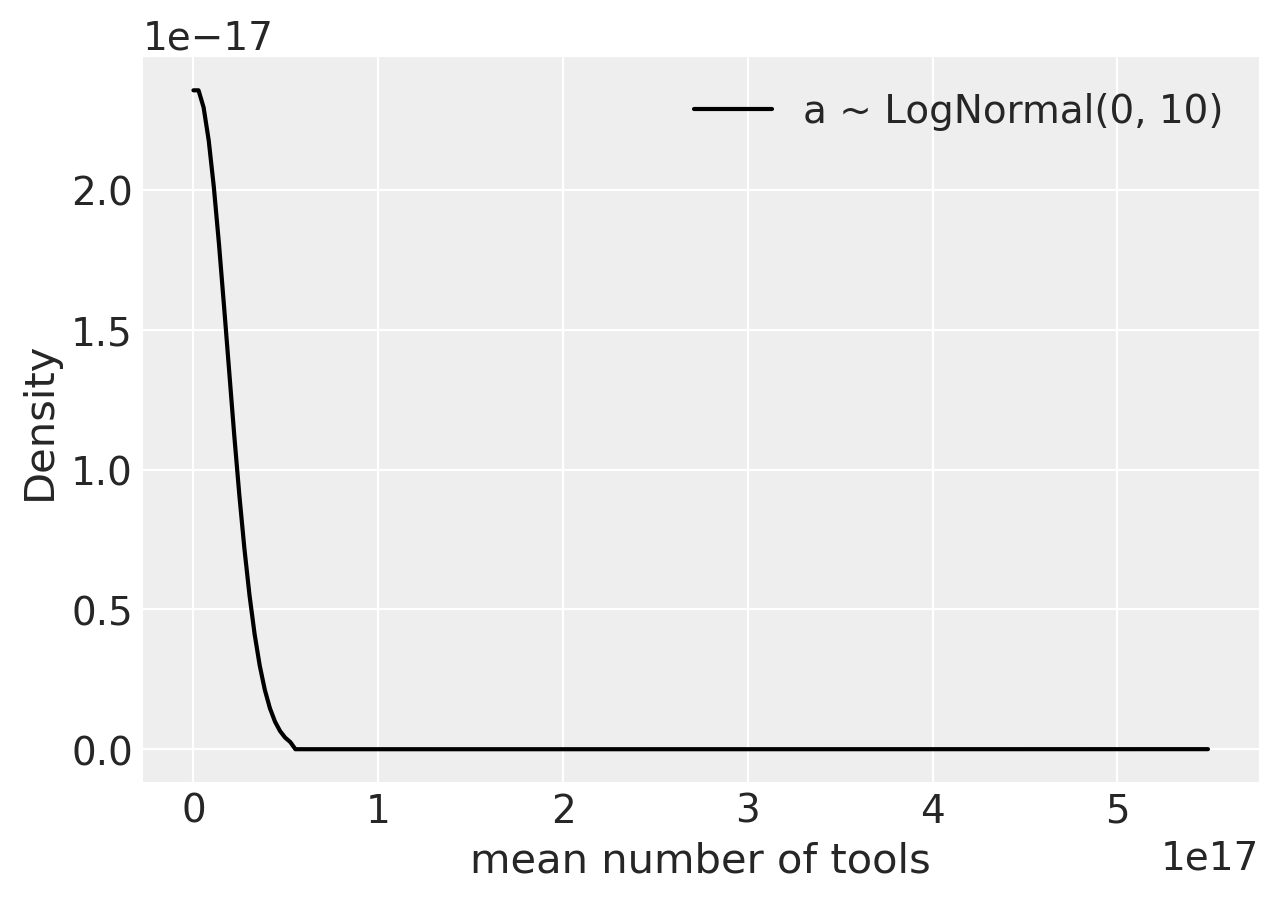

In [24]:
ax = az.plot_kde(
    pm.Lognormal.dist(mu = 0.0, sigma = 10.0).random(size=20000),
    label="a ~ LogNormal(0, 10)",
    plot_kwargs={"color": "k"},
)
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

The fact to appreciate is that a log link puts half of the real numbers - the negative numbers below zero and one on the outcome scale. So if your prior puts half its mass below zero, then half the mass will end up being between zero and one on the outcome scale.

Lets have another go with those priors


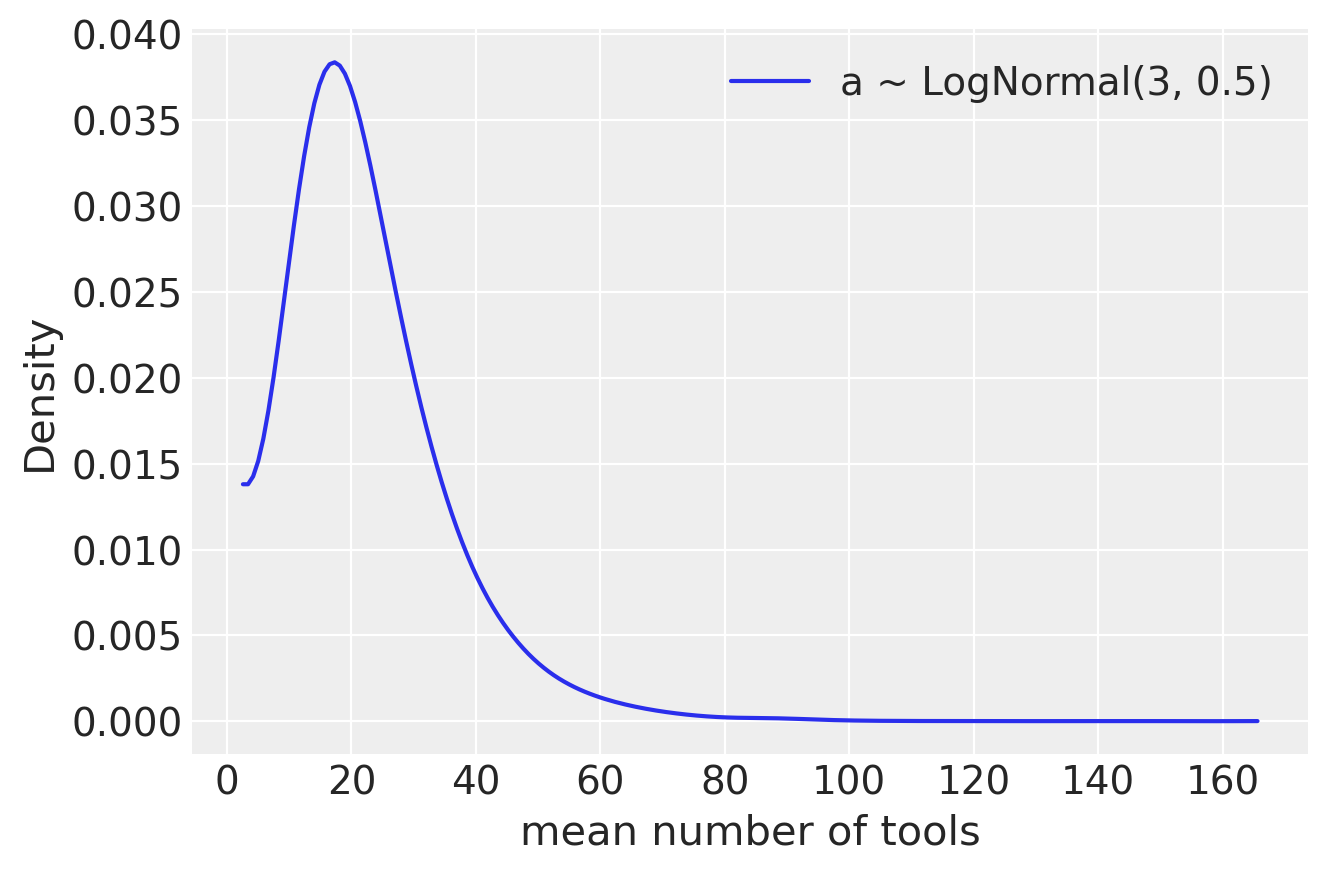

In [25]:
ax = az.plot_kde(pm.Lognormal.dist(3.0, 0.5).random(size=20_000), label="a ~ LogNormal(3, 0.5)")
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

Next we need a prior for beta, lets try a pretty flat prior again

In [26]:
def kline_prior_plot(N: int = 100, b_prior: str = "bespoke", x_scale: str = "stdz", ax=None):
    """
    Utility function to plot prior predictive checks for Kline Poisson model.
    N: number of prior predictive trends.

    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_ylabel("total tools")

    itcpts = np.random.normal(3.0, 0.5, N)
    if b_prior == "conventional":
        slopes = np.random.normal(0.0, 10.0, N)
        ax.set_title("b ~ Normal(0, 10)")
    elif b_prior == "bespoke":
        slopes = np.random.normal(0.0, 0.2, N)
        ax.set_title("b ~ Normal(0, 0.2)")
    else:
        raise ValueError(
            "Prior for slopes (b_prior) can only be either 'conventional' or 'bespoke'."
        )

    x_seq = np.linspace(np.log(100), np.log(200_000), N)
    ax.set_ylim((0, 500))
    if x_scale == "log":
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("log population")
    elif x_scale == "natural":
        for a, b in zip(itcpts, slopes):
            ax.plot(np.exp(x_seq), np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_xlabel("population")
    else:
        x_seq = np.linspace(-2, 2, N)
        for a, b in zip(itcpts, slopes):
            ax.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
        ax.set_ylim((0, 100))
        ax.set_xlabel("log population (std)")

    return ax

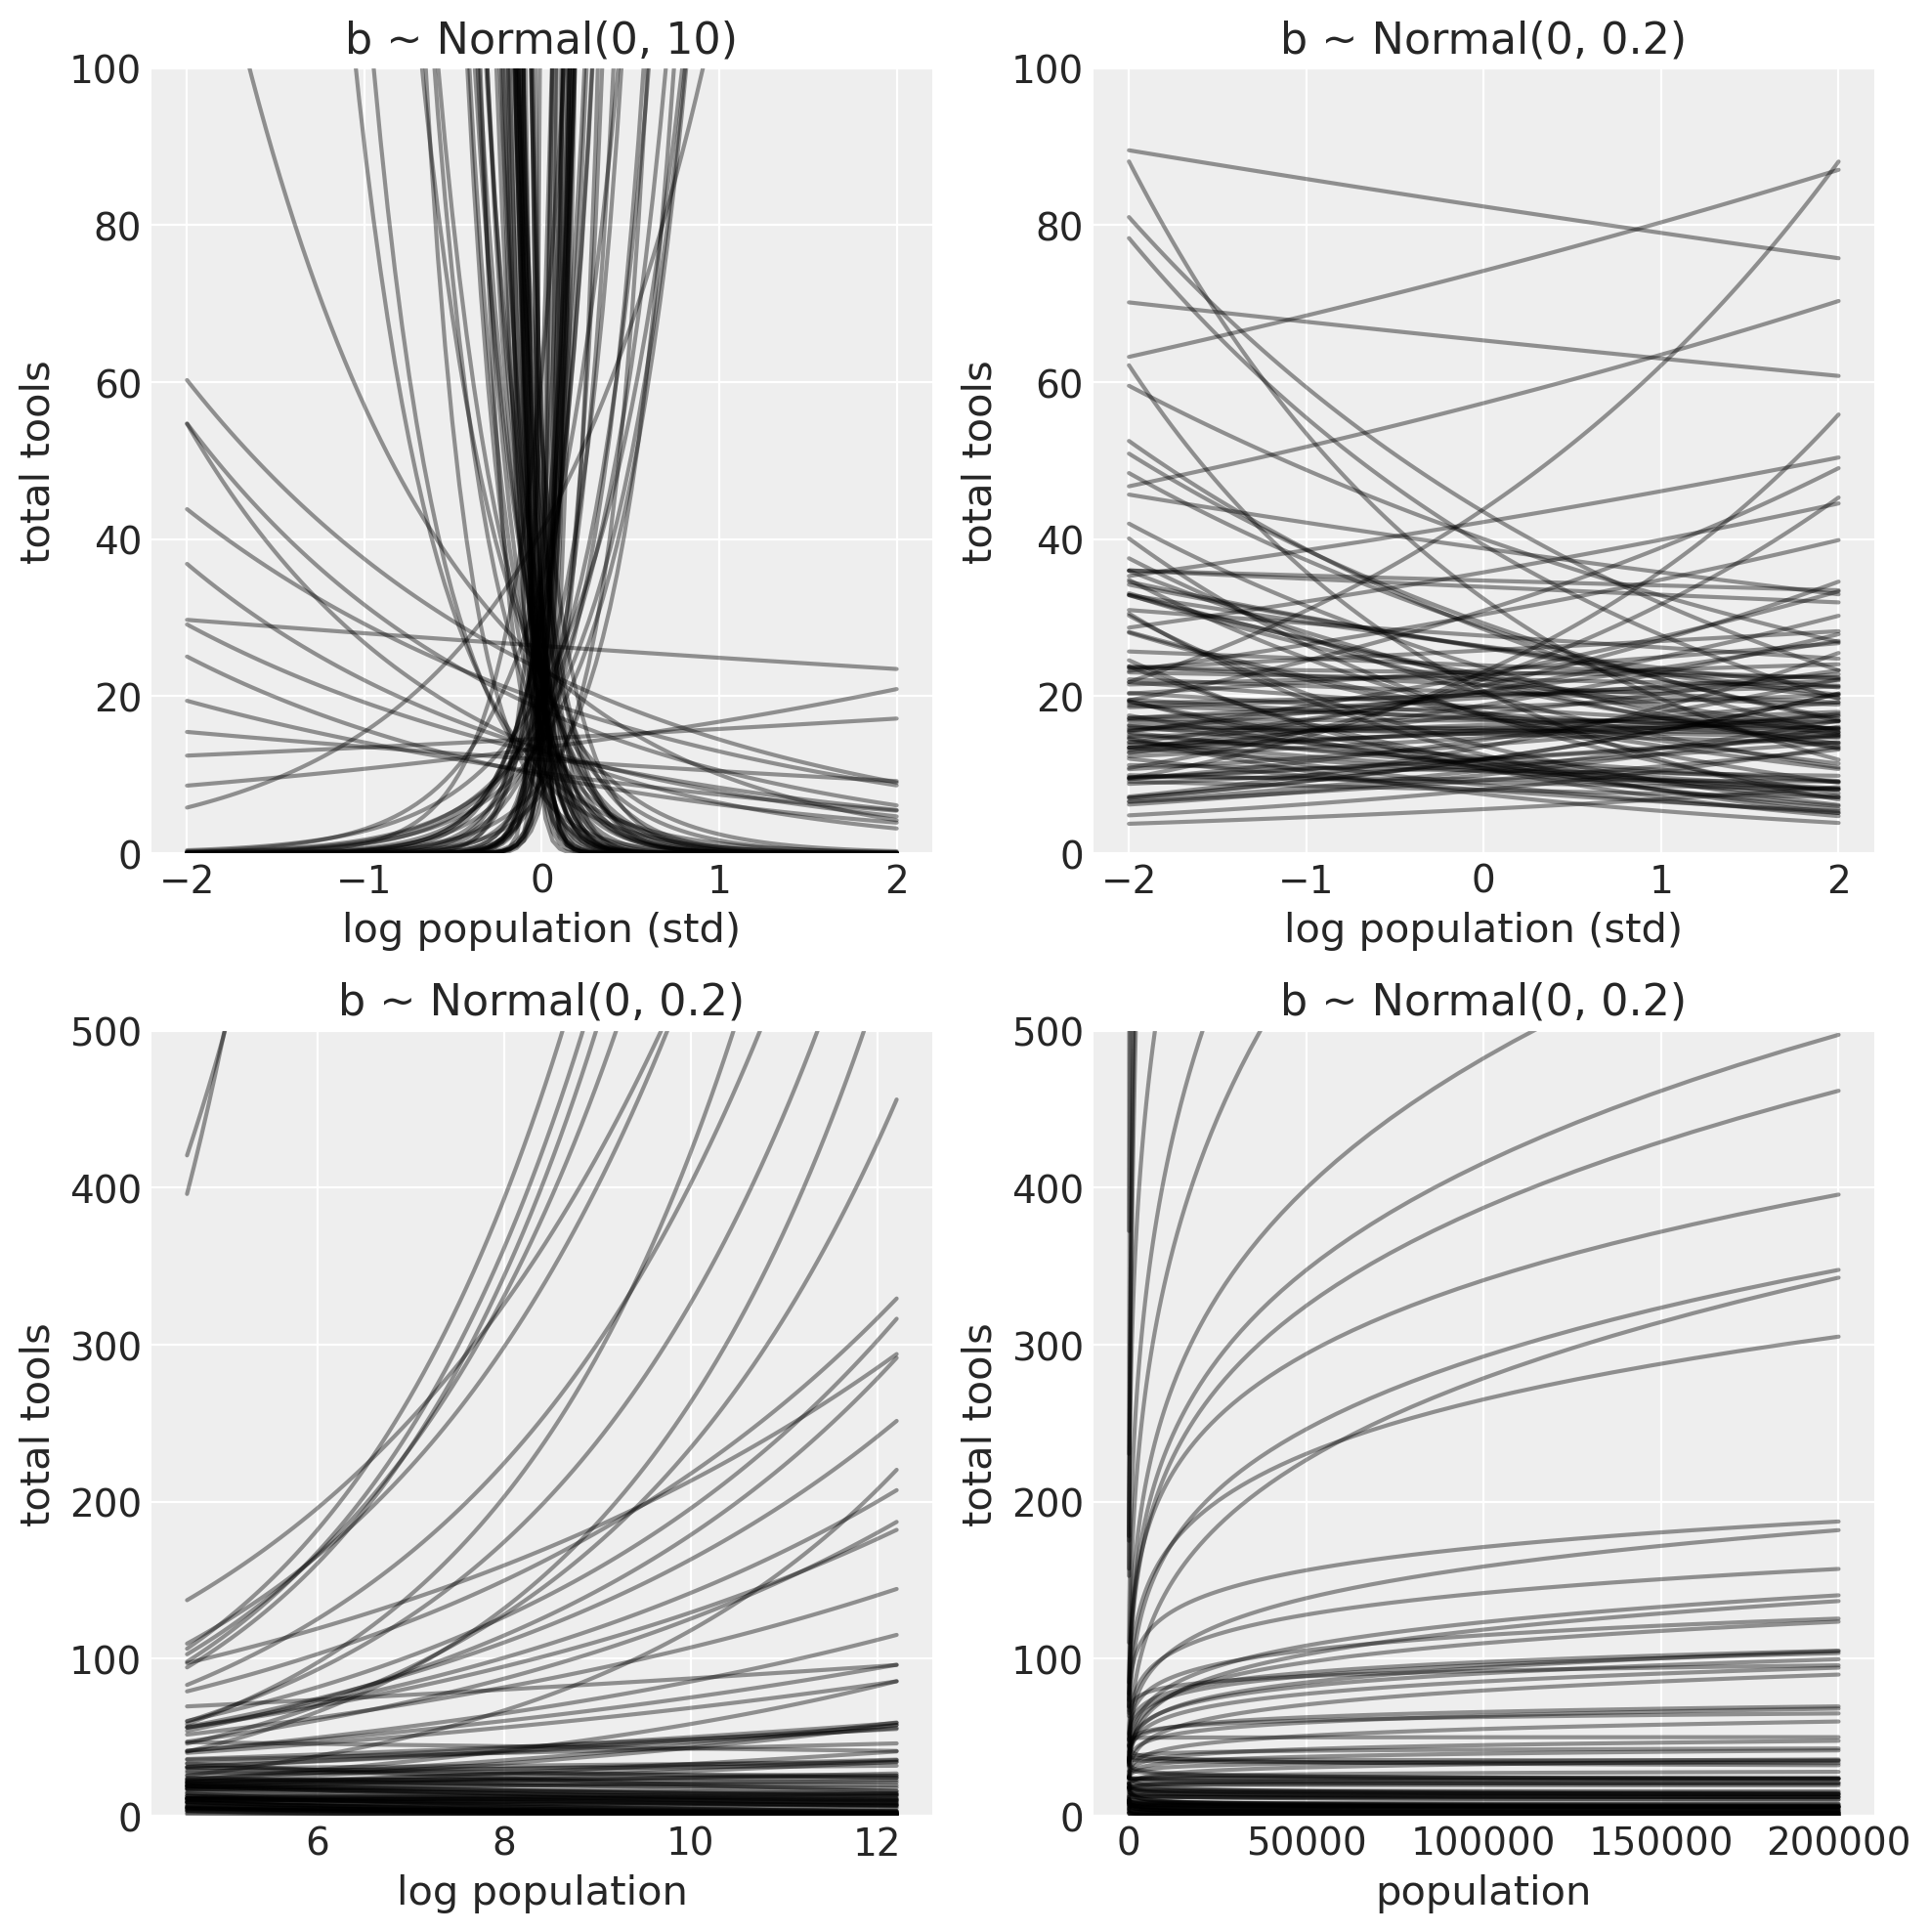

In [27]:
_, ax = plt.subplots(2, 2, figsize=(10, 10))
kline_prior_plot(b_prior="conventional", x_scale="stdz", ax=ax[0][0])
kline_prior_plot(b_prior="bespoke", x_scale="stdz", ax=ax[0][1])
kline_prior_plot(b_prior="bespoke", x_scale="log", ax=ax[1][0])
kline_prior_plot(x_scale="natural", ax=ax[1][1])
plt.tight_layout();

In [34]:
# intercept only
with pm.Model() as m11_9:
    a = pm.Normal("a", 3.0, 0.5)
    T = pm.Poisson("total_tools", pm.math.exp(a), observed=dk.total_tools)
    trace_11_9 = pm.sample(tune=3000, random_seed=RANDOM_SEED)

# interaction model
with pm.Model() as m11_10:
    a = pm.Normal("a", 3.0, 0.5, shape=2)
    b = pm.Normal("b", 0.0, 0.2, shape=2)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = pm.math.exp(a[cid] + b[cid] * P_)

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_10 = pm.sample(tune=3000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:09<00:00, 1519.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [00:14<00:00, 978.49draws/s] 


Before we distest everything about this model, lets remind ourselves about all the variables.

a and b, - these are the intercept and slope for the linear model

c_id - this is the categorical variable which describes high and low contact

P - this is the population data. 

lam - this represents the linear model as a log-normal? but it says exp? not sure why but will have a look at this shortly.
FOUND IT - this is because its a rearrangement of log(lam) = a+bp

Other observations. Unlike in previous examples, the data has been explicitly filed away in the pm.Data object. The model runs without this line, but from looking at the documentation it makes it easier to access methods in theano

Ok, now lets compare the intercept only model with the full poisson linear model. Looking below, the first thing we notice is that there are some warnings - there are some highly influential points.That shouldnt be surprising - this is a small dataset

In [35]:
az.compare({"m11_9": trace_11_9, "m11_10": trace_11_10})

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m11_10,0,82.927424,5.768162,0.000000,0.998525,30.296232,0.000000,True,deviance
m11_9,1,141.502929,8.310529,58.575506,0.001475,11.489987,32.255324,True,deviance


In [36]:
# store pareto-k values for plot:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/stats/stats.py:526: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In this sample, a major source of overfitting risk is the highly influential point flagged by PSIS. Lets plot the posterior predictions now, and I'll scale and label the highly influenctial points with their pareto k values.

In [37]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns)

with m11_10:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_10, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

100%|██████████| 2000/2000 [00:02<00:00, 973.23it/s]


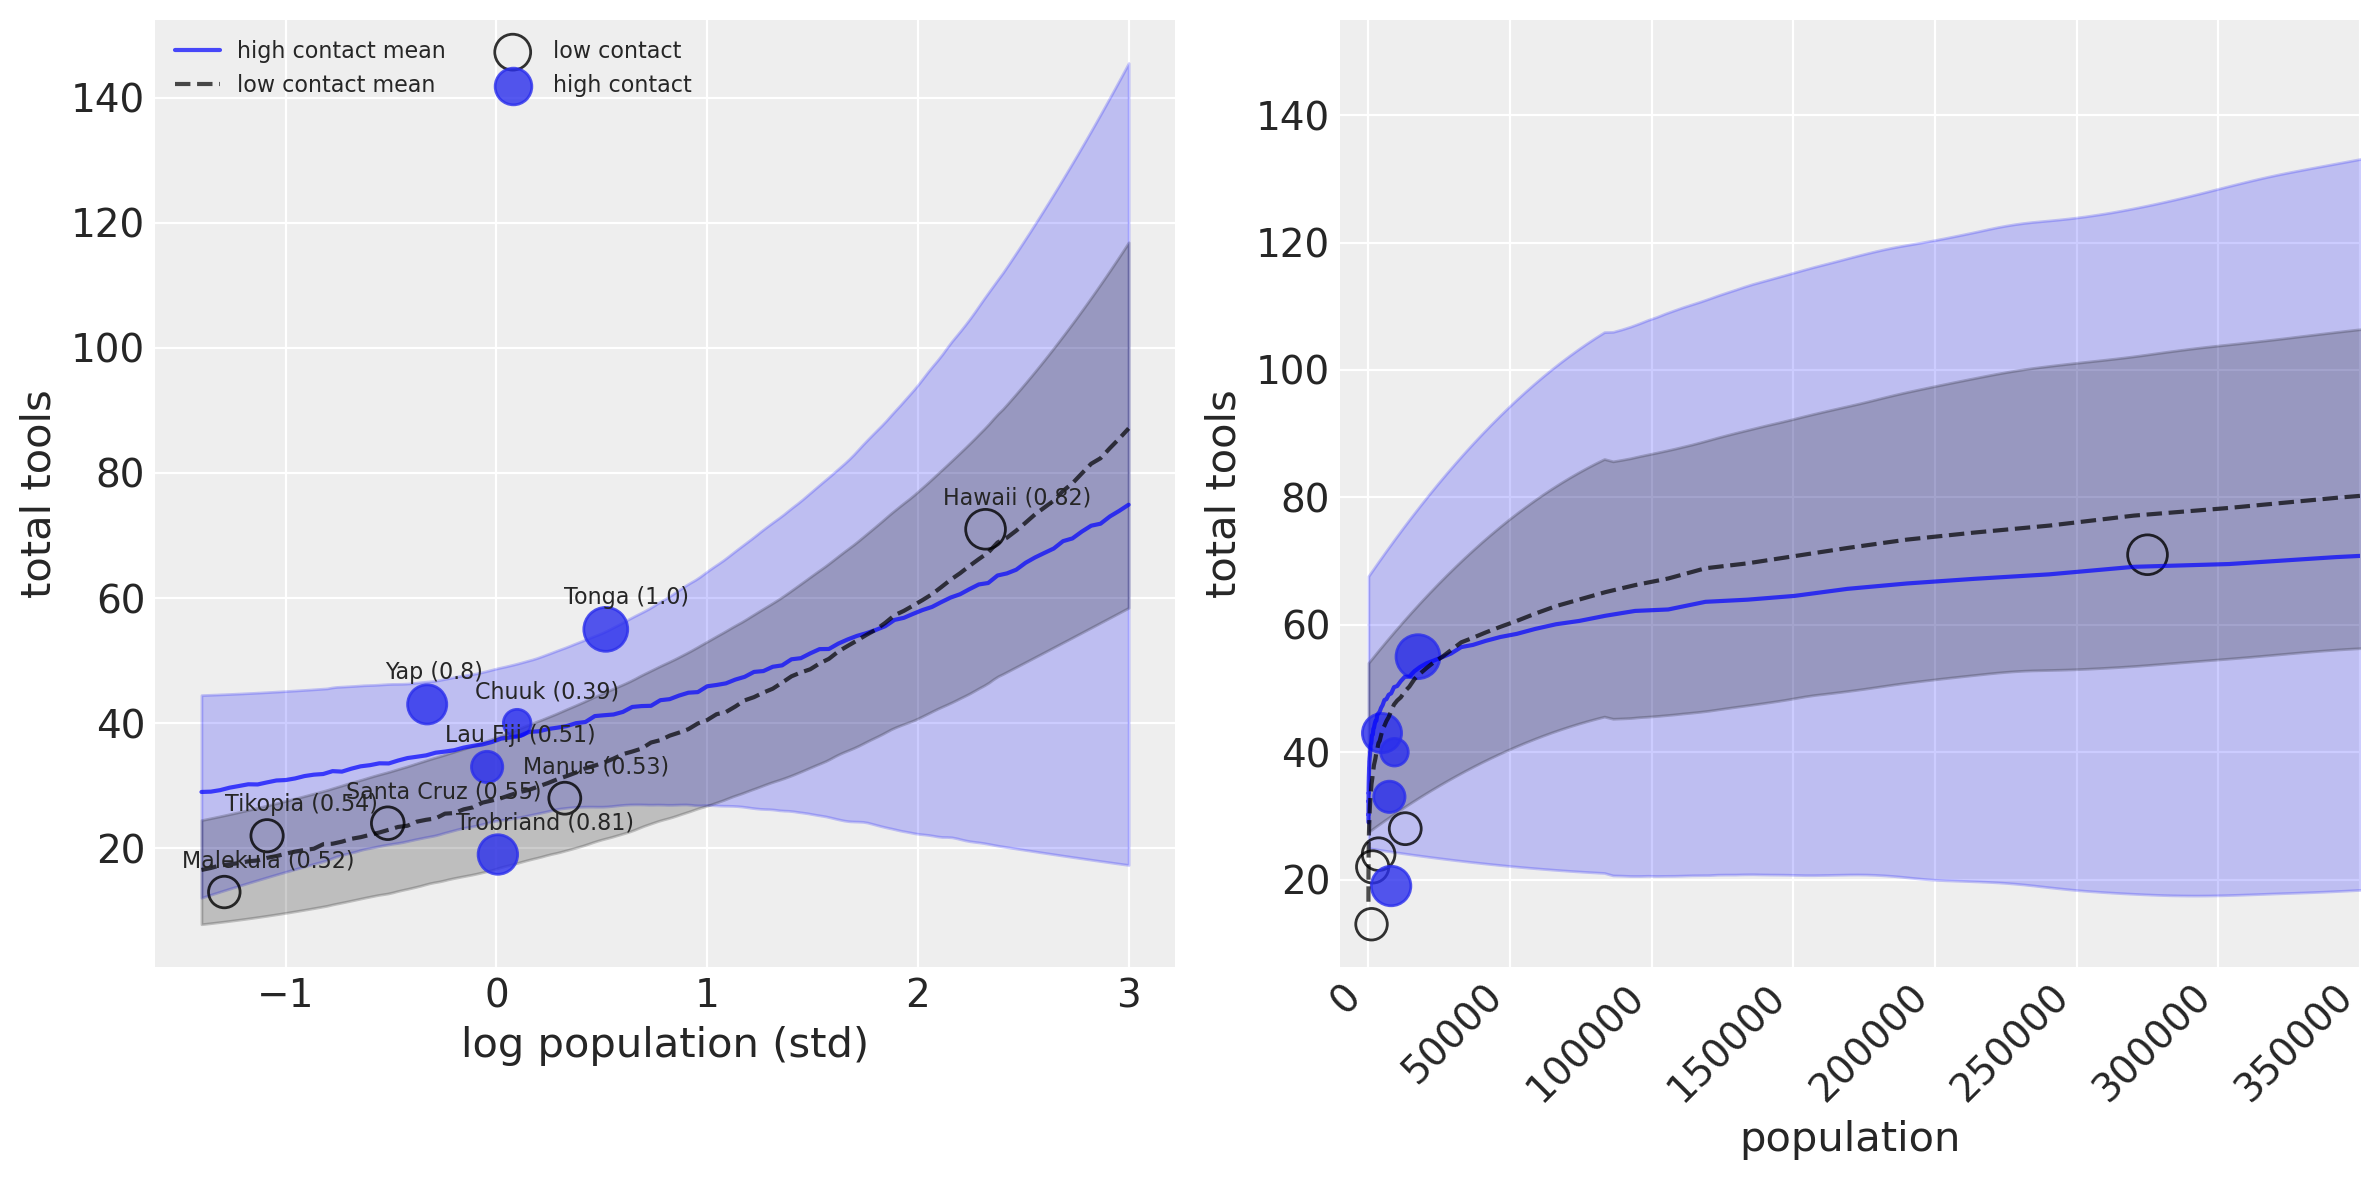

In [38]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# scale point size to Pareto-k:
k /= k.max()
psize = 250 * k

# Plot on standardized log scale:

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display names and k:
mask = k > 0.3
labels = dk.culture.values[mask]
for i, text in enumerate(labels):
    ax0.text(
        P[mask][i] - 0.2,
        dk.total_tools.values[mask][i] + 4,
        f"{text} ({np.round(k[mask][i], 2)})",
        fontsize=8,
    )

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("log population (std)")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize and exponentiate values of standardized log pop:
P_seq = np.linspace(-5.0, 3.0, ns)
P_seq = np.exp(P_seq * np.log(dk.population.values).std() + np.log(dk.population.values).mean())

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

From reviewing these results, certain things look a little suspect, particularly at the high population. The model seems to think that at high populations you get more tools if you are a lot contact society. This runs contrary to common sense. And if you look at the credible intervals it shows that the high contact model doesnt really know what is going on.

This model can produce a silly pattern, because it lets the intercept be a free parameter. Why is this bad? Because it means there is no guarantee that the trend for lamda will pass through the origin where total tools = zero and the population size equals zero. When there are zero people, there are also zero tools! So we get the intercept for free, if we stop and think.

Instead of using a conventional GLM, we could use the predictions of an actual model of the relationship between population size and tool kit complexity. This means replacing the alpha+beta * x with a formula that has been formulated to represent the underlying behaviour of the system

In [39]:
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:30<00:00, 530.04draws/s]
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/

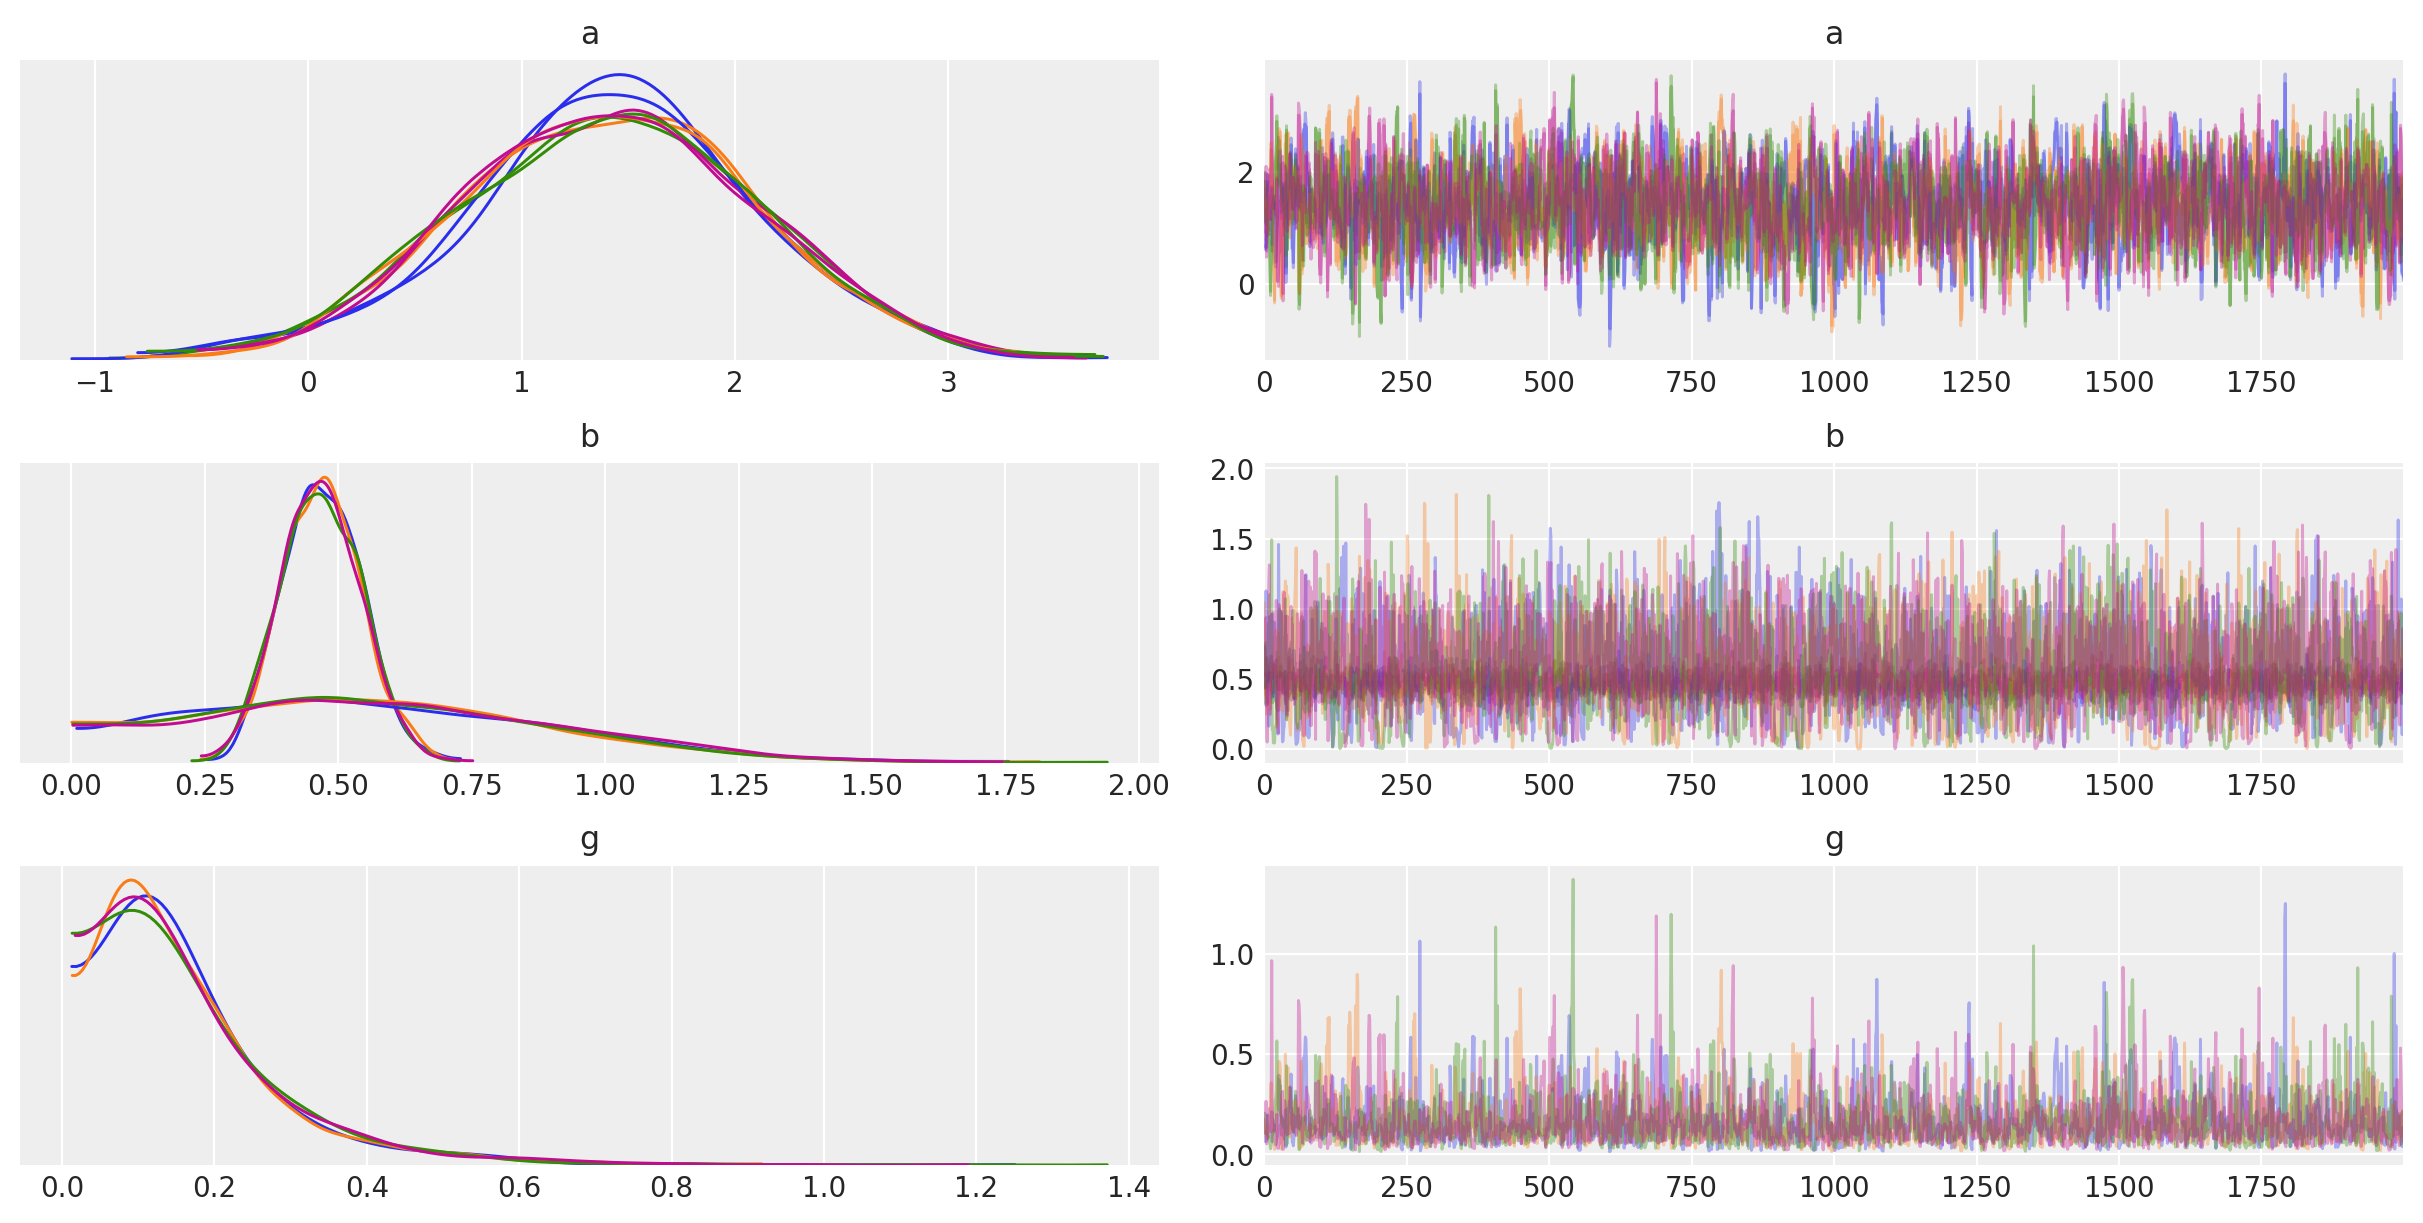

In [45]:
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (pm.math.exp(a[cid]) * P_ ** b[cid]) / g  #This is the scientifically based model that replaces the linear model

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools)
    trace_11_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)
az.plot_trace(trace_11_11, compact=True);

In [43]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])["total_tools"]

lmu0, lmu1 = lam0.mean(0), lam1.mean(0)

100%|██████████| 8000/8000 [00:08<00:00, 889.53it/s]


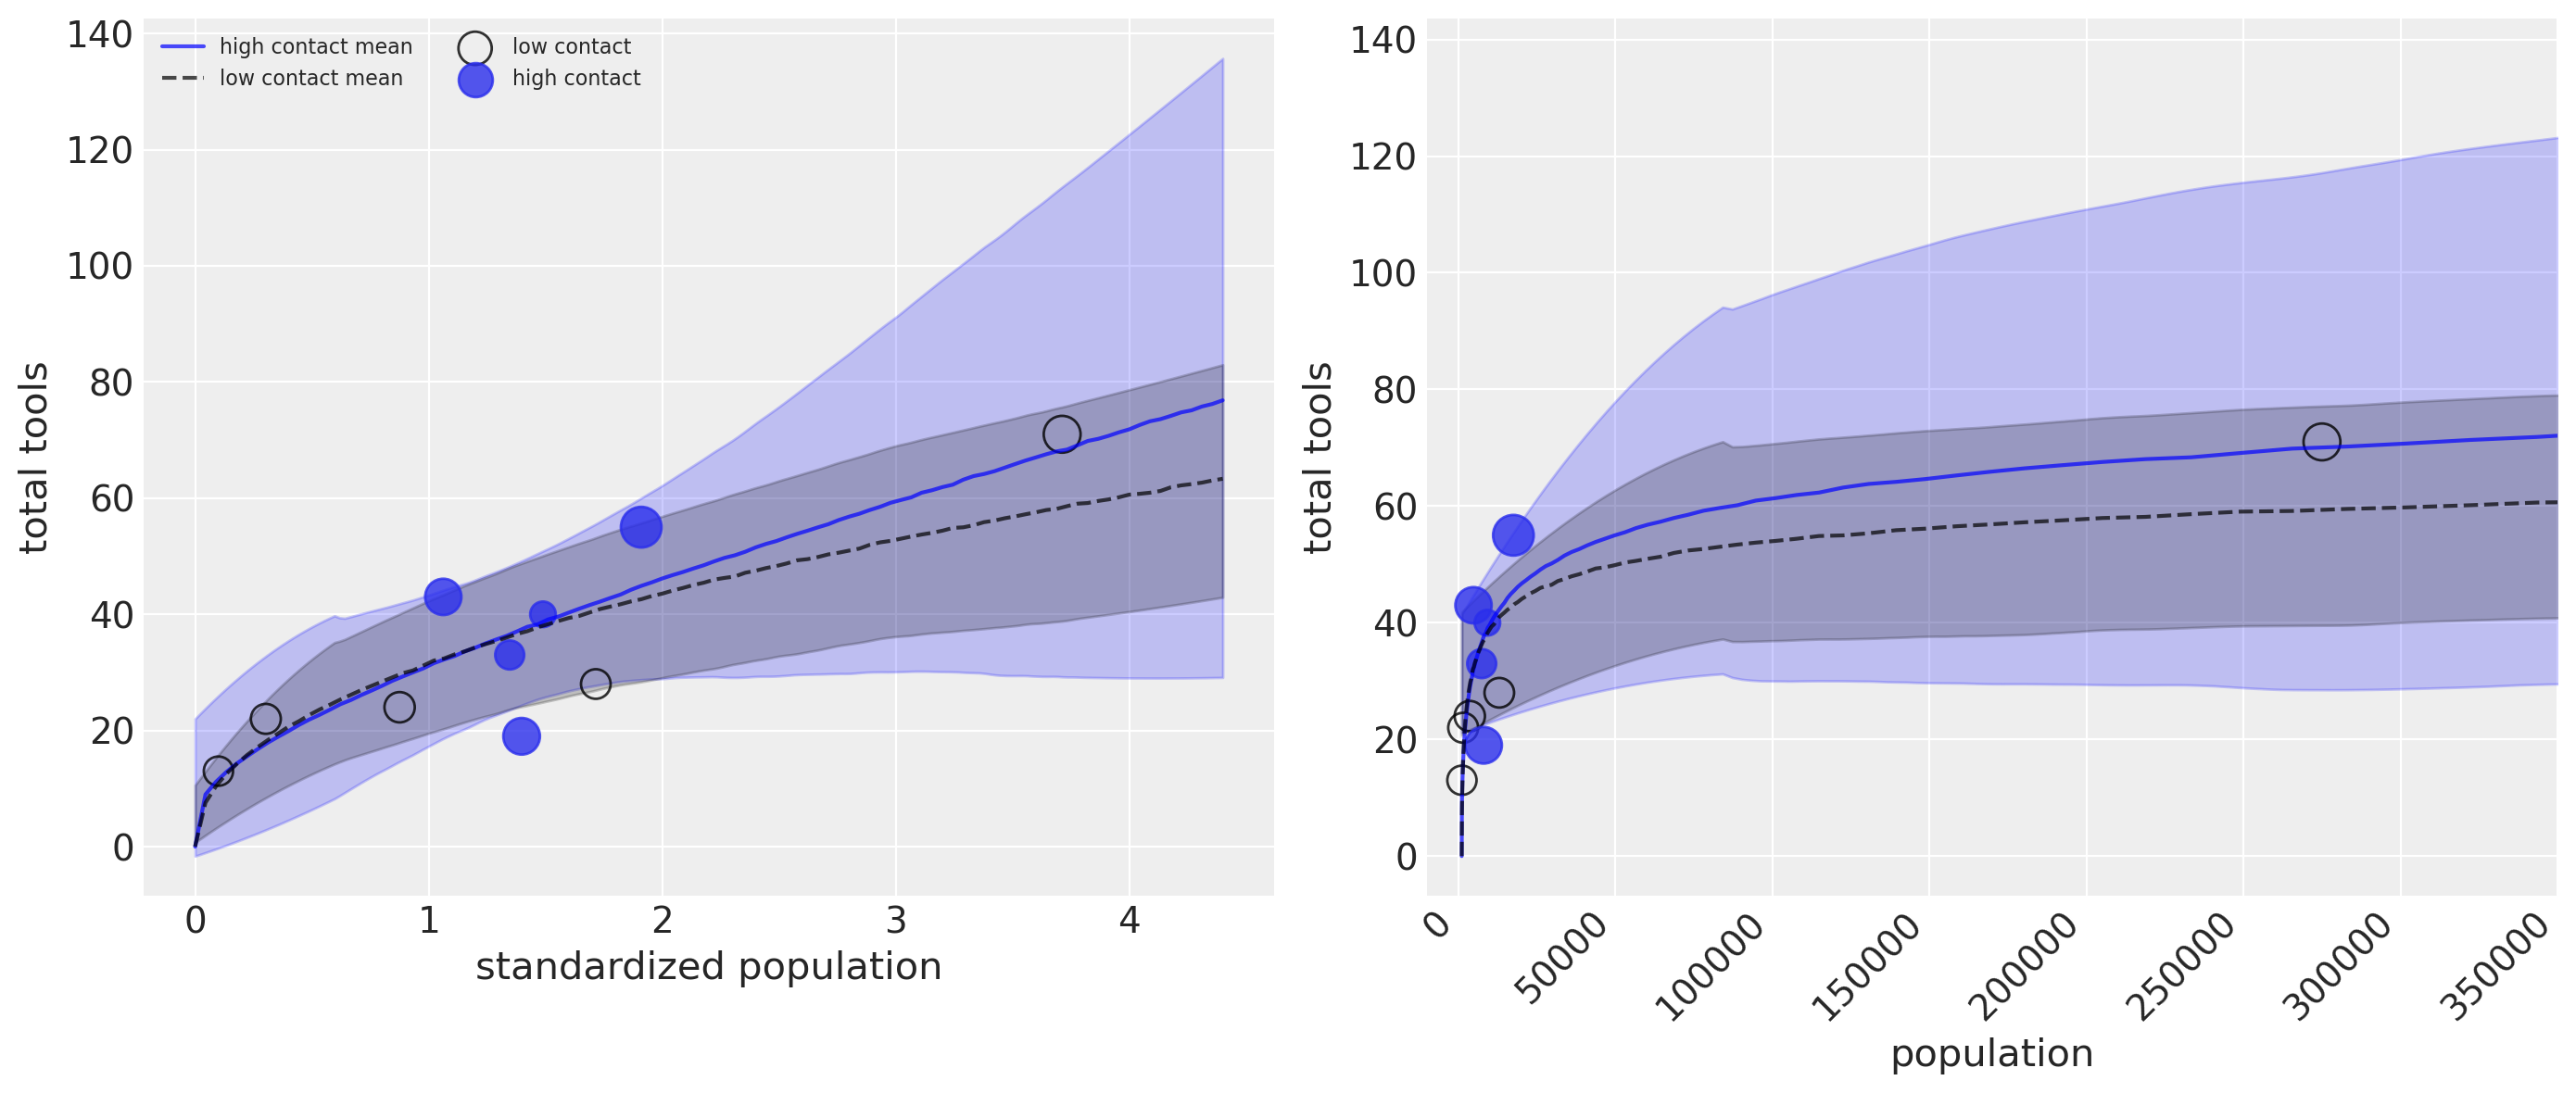

In [44]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on standardized log scale:
az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1, color="b", alpha=0.7, label="high contact mean")

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    P[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(P[index], dk.total_tools[index], s=psize[index], alpha=0.8, label="high contact")
ax0.set_xlabel("standardized population")
ax0.set_ylabel("total tools")
ax0.legend(fontsize=8, ncol=2)

# Plot on natural scale:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)

az.plot_hpd(P_seq, lam1, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1, color="b", alpha=0.7)

az.plot_hpd(P_seq, lam0, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 350_000))
ax1.set_xlabel("population")
ax1.set_ylabel("total tools")
plt.tight_layout();

## Negative Binomial (gamma-Poisson) Models. 
Typically there is a lot of unexplained variation in Poisson models. Presumably this additional variation arises from unobserved influences that vary from case to case, generating variation in the true lamdas. Ignoring this variation, can cause confounds just like it can for binomial models. So a very common extention of Poisson GLMs is to swap the Poisson distribution for something called a NEGATIVE BINOMIAL distribtution. This is really a POISSON distribtuion is disguise and is sometimes called a GAMMA-POISSON distribution for this reason.

## Exposure and offset
The parameter lam is the expected value of a Poisson model, but its also commonly thought of as a rate. Both interpretations are correct, and realising this allows us to make poisson models for which the EXPOSURE varies across cases. i. Suppose for example that a neighbouring monastery performs weekly totals of completed manuscripts while your monastery does daily totals. If you come into possession of both sets of records, how could yoi analyze both in the same model, given that the counts are aggregated over different amounts of time, different exposures?

We'll simulate this example. both to provide another example of dummy-data simulation as well as to ensure we get the right answer from the offset approach. Suppose, as we did earlier that you own a monastary. The data available to you about the rate at which manuscripts are complete is totalled up each day. Suppose the true rate is lam=1.5 manuscripts per day. We can simulate a month of daily counts

In [51]:
from scipy.stats import poisson

num_days = 30
y = poisson.rvs(mu=1.5, size=num_days)
y

array([3, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 3, 3, 1, 1,
       0, 2, 1, 3, 0, 5, 2, 1])

Also suppose that your monastery is turning a tidy profit, so you are considering purchasing another monastery. Before purchasing, you'd like to know how productive the new monastery might be. Unfortunately the current owners don't keep daily records, so a head to head comparison of the daily totals isn't possible. Instead the owners keep weekly totals, Suppose the rate at the new monastery is actually lam=0.5 manustripts per day. To simulate data on a weekly basis, we just multiple this average by 7. The exposure

In [53]:
num_weeks = 4
y_new = poisson.rvs(mu=0.5*7, size=num_weeks)
y_new

array([1, 3, 8, 3])

To analyse both y, totaled up daily, and y_new, totaled up weekly, we just add the logarithm of the exposure to the linear model. Lets not build a dataframe to organise the counts and help you see the exposure for each case

In [54]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype("float")
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])
y_all, exposure, monastery

d = pd.DataFrame({'y': y_all,
                 'days': exposure,
                 'monastery': monastery})

d

,y,days,monastery
0,3,1.0,0
1,2,1.0,0
2,1,1.0,0
3,2,1.0,0
4,1,1.0,0
5,1,1.0,0
6,1,1.0,0
7,1,1.0,0
8,2,1.0,0
9,2,1.0,0


To fit the model, and estimate the rate of manuscript production at each monastery, we just compute the log of each exposure and then include that variable in the linear model.

In [61]:
# compute the offset:
log_days = np.log(d['days'].values) #theano tensor backend doesn't like pandas series

# fit the model:
with pm.Model() as m11_12:
    a = pm.Normal("a", 0.0, 1.0)
    b = pm.Normal("b", 0.0, 1.0)

    lam = pm.math.exp(log_days + a + b * monastery)

    obs = pm.Poisson("y", lam, observed=y_all)

    trace_11_12 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:04<00:00, 2570.50draws/s]


To compute the posterior distributions of lamda in each monastery, we sample from the posterior and then just use the linear model, but without the offset now. We don't use the offset again, when computing prediction, because the parameters are already on the daily scale, for both monasteries

In [62]:
lambda_old = np.exp(trace_11_12["a"])
lambda_new = np.exp(trace_11_12["a"] + trace_11_12["b"])

az.summary({"lambda_old": lambda_old, "lambda_new": lambda_new}, kind="stats", round_to=2)

,mean,sd,hpd_3%,hpd_97%
lambda_old,1.59,0.23,1.20,2.01
lambda_new,0.58,0.14,0.32,0.82


The new monastery produces abot half as many manuscripts per day. So you aren't going to pay that much for it